In [2]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

/Users/ia4118/anaconda3/envs/data_science/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
# Enable LaTeX rendering
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 18
})

We reshape and normalize the feature data and visualize the MNIST data

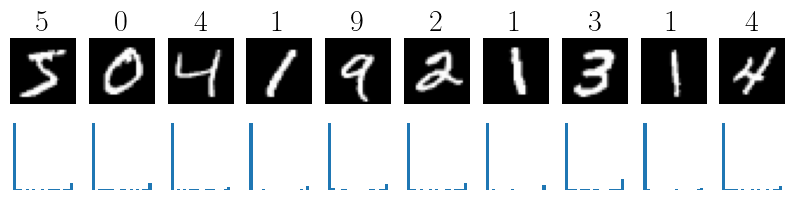

In [13]:
import matplotlib.pyplot as plt

X_numpy = X.to_numpy()
X_numpy /= np.max(X_numpy)
N_features = X_numpy.shape[1]
N_samples = X_numpy.shape[0]
X_reshaped = np.reshape(X_numpy, (N_samples, 28, 28))

fig, axes = plt.subplots(2,10,figsize=(10, 2))
axes = axes.flatten()

for i, ax in enumerate(axes[:10]):
    ax.imshow(X_reshaped[i,:,:], cmap='gray')
    ax.axis('off')
    ax.set_title(f'{y[i]}')

for i, ax in enumerate(axes[10:]):
    ax.hist(X_reshaped[i,:,:].flatten(), bins=np.linspace(0,1,20))
    ax.axis('off')
plt.show()




PCA simplifies the data lowering the dimensions in latent variables. Latent variables are unobservable but can be directly computed from the feature data that we have. In this case, our data has $N_{\text{features}}=784$. 

The mean feature vector ($N_{\text{samples}} \times N_{\text{features}}  = 70000 \times 784$) is computed as

\begin{equation}
\overline{x} = \frac{1}{N} \sum_i^{N_{\text{samples}}} {X_i} 
\end{equation}

Let's consider a normalized vector $u$ in feature space $u u^T = 1$. We can compute the mean projected data by multiplying $u \overline{x}$

Text(0.5, 0, 'Pixel value')

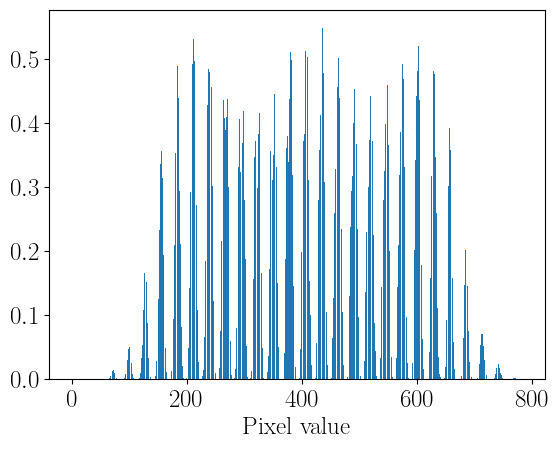

In [14]:
mean_projected = np.mean(X_numpy, axis=0)
plt.bar(np.arange(N_features), mean_projected)
plt.xlabel('Pixel value')

If we assume any $u$ vector in the feature space, the variance of the projected data can be described by:

\begin{equation}
f(u) = \frac{1}{N_{\text{samples}}} \sum_{i=1}^{N_{\text{samples}}} (u x_i - u \overline{x})^2 = u^T S u, 
\end{equation}
where 
\begin{equation}
S = \frac{1}{N_{\text{samples}}} \sum_{i=1}^{N_{\text{samples}}} (x_i - \overline{x}) (x_i - \overline{x})^T
\end{equation}.

Maximizing $\frac{df}{du}$ while enforcing $uu^T=1$:

\begin{equation}
 \frac{df}{du} = 0 = Su - \lambda u
\end{equation}

From this it is shown that $u$ is the eigenvector of S and $\lambda$ the eigenvalue


In [18]:
def compute_covariance(X):
    X_numpy_centered = X - np.mean(X, axis=0)
    X_numpy_centered_T = X_numpy_centered.T
    S = np.matmul(X_numpy_centered_T, X_numpy_centered)
    S /= X.shape[0]
    return S

A faster way to compute the covariance matrix is through SVD (Singular Value Decomposition), where $X=U E V^T$
\begin{equation}
S = \frac{1}{N} X^T X = \frac{1}{N} V E^2 V^T = V \frac{E^2}{N} V^T
\end{equation}
The columns of $V$ through SVD are the eigenvectors of the covariance matrix S needed for PCA analysis

(70000, 784)


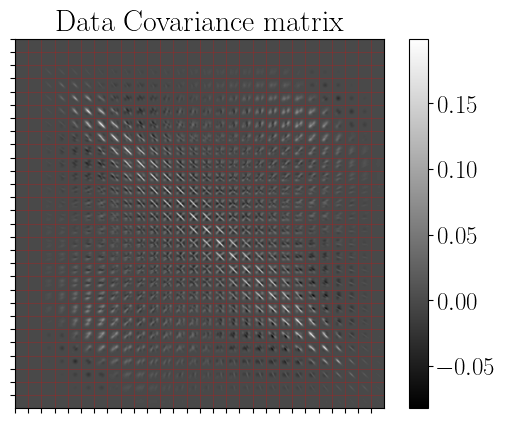

In [19]:
print(X_numpy.shape)
S = compute_covariance(X_numpy)
#visualize matrix
plt.imshow(S, cmap='gray')
plt.title('Data Covariance matrix')
plt.colorbar()
plt.grid(True, which='both', color='red', linewidth=0.5, alpha=0.3)
plt.xticks(np.arange(0, 784, 28),labels=[])
plt.yticks(np.arange(0, 784, 28),labels=[])
plt.show()
#turn off x tick labels

Note that the data covariance is a matrix of $N_{\text{features}} \times N_{\text{features}}$, showing the covariance between the different pixels of the images. We can see high covariance in the diagonal (close pixels) while less covariance on the edges (pixels far apart). The cross pattern observed is because vertical and horizontal pixels have high covariance. 

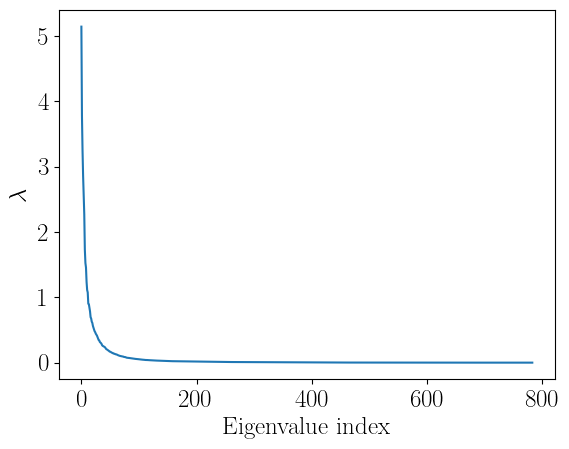

In [20]:
def compute_pca(S):
    # Force symmetry to avoid numerical issues
    S = (S + S.T) / 2
    eigenvalues, eigenvectors = np.linalg.eigh(S)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues_sorted = eigenvalues[idx]
    eigenvectors_sorted = eigenvectors[:, idx]
    return eigenvalues_sorted, eigenvectors_sorted

eigenvalues_sorted, eigenvectors_sorted = compute_pca(S)

#Plot the eigenvalues
plt.plot(eigenvalues_sorted)
plt.xlabel('Eigenvalue index')
plt.ylabel('$\lambda$')
plt.show()

From the plot we visualize that the relevant eigenvectors/eigenvalues are $<100$. Let's visualize some of the eigenvectors from the PCA analysis

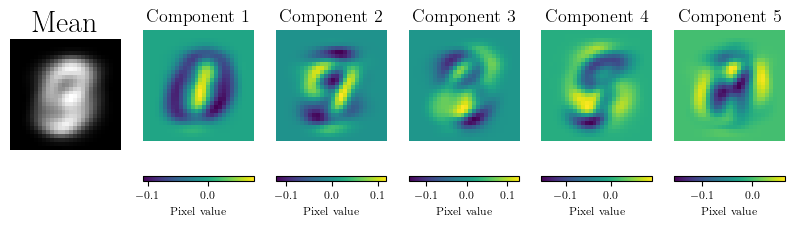

In [21]:
def plot_mean_and_components(X, M=4):
    mean = np.mean(X, axis=0)
    S = compute_covariance(X)
    lambdas , E = compute_pca(S)
    # Plot components
    fig, axes = plt.subplots(1,M+1,figsize=(10,3))
    axes[0].imshow(mean.reshape(28, 28), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Mean')
    
    for i in range(M):
        component = E[:, i].reshape(28, 28)
        axes[i+1].imshow(component, vmin = np.min(component), vmax = np.max(component))
        #add colorbar 
        cbar = axes[i+1].figure.colorbar(axes[i+1].images[0], ax=axes[i+1], orientation='horizontal')
        cbar.ax.set_xlabel('Pixel value',fontsize=8)
        cbar.ax.tick_params(labelsize=8)
        axes[i+1].axis('off')
        axes[i+1].set_title(f'Component {i+1}',fontsize=13)
    plt.show()
    return lambdas, E

lambdas_all, E_all = plot_mean_and_components(X_numpy,5)

As we can see the mean is a mix of digits and the components are not clear to what digit they represent. 
We can now reduce the dimensionality of the images by $M<D$ where $D$ is the original feature dimensionality. The PCA can be then reconstructed to match the same dimensions while adding the mean feature values. Note that because we have multiple digits in the dataset we need a high $M$ to visualize the digit

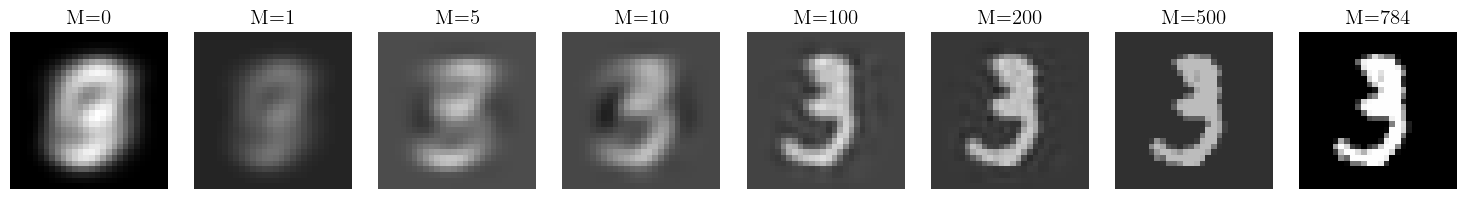

In [22]:
def plot_pca_reconstruction(X,M,eigenvectors):
    X_numpy_centered = X - np.mean(X, axis=0)
    N_samples = X.shape[0]
    _, ax = plt.subplots(1,len(M),figsize=(15,8))
    ax = ax.flatten()
    for i,m in enumerate(M):
        U = eigenvectors[:,:m]
        X_pca_reduced = np.matmul(X_numpy_centered, U)
        X_pca_reconstructed = np.matmul(X_pca_reduced, U.T) + np.mean(X_numpy, axis=0)
        X_pca_reconstructed_reshaped = np.reshape(X_pca_reconstructed, (N_samples, 28, 28))
        vmin = np.min(X_pca_reconstructed_reshaped)
        vmax = np.max(X_pca_reconstructed_reshaped)     
        ax[i].imshow(X_pca_reconstructed_reshaped[10,:,:], vmin=vmin, vmax=vmax,cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(f'M={m}',fontsize=15)
    plt.tight_layout()
    plt.show()

M = [0,1,5,10,100,200,500,784]
plot_pca_reconstruction(X_numpy,M,E_all)

Note that with mean ($M=0$) and adding some modes is not enough to distinguish the digit. The reason is that the data we are using contains multiple digits so it is difficult for the PCA to detect the specifics of each digit. Let's now filter the data and repeat the process

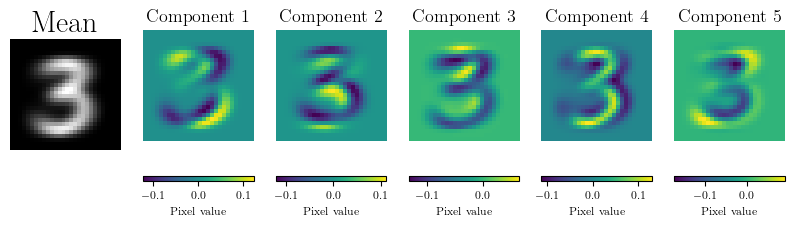

In [23]:
X_numpy_3 = X_numpy[y == "3"]
lambdas_digit_3, E_digit_3 = plot_mean_and_components(X_numpy_3,M=5)

Now, if we reconstruct the data with this new PCA we can see that the digit is more distinguishable. 


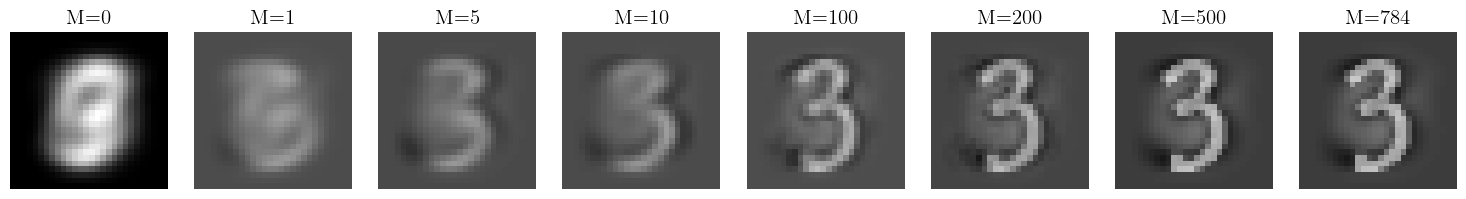

In [24]:
plot_pca_reconstruction(X_numpy_3,[0,1,5,10,100,200,500,784],E_digit_3)